In [89]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone
from itertools import combinations
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier


In [90]:
df_wine = pd.read_csv('wine.data',header=None)

columns_list = columns_list = ['label',
                   'alcohol',
                   'malic acid',
                   'ash',
                   'alcalinity of ash',
                   'magnesium',
                   'total phenols',
                   'flavanoids',
                   'nonflavanoid phenols',
                   'proanthocyanins',
                   'color intensity',
                   'hue',
                   'od280/od315 of diluted wines',
                   'proline']

df_wine.columns = columns_list

# splitting the data into training and test data
x = df_wine.iloc[:,1:]
y = df_wine['label']

x_train,x_test,y_train,y_test = train_test_split(x,y, 
                                                 test_size=0.3,
                                                 stratify=y,
                                                 random_state=0)

# standardization of the training set
std = StandardScaler()
x_train_std = pd.DataFrame(std.fit_transform(x_train))

features_list = [x for x in columns_list if x != 'label']

x_train_std.columns = features_list

# standardization of the test dataset

x_test_std = pd.DataFrame(std.fit_transform(x_test))
x_test_std.columns = features_list

In [91]:
class SBS:
    def __init__(self, estimator, k_features, scoring=accuracy_score, test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, x, y):
        x = np.asarray(x)
        y = np.asarray(y)
        x_train, x_test, y_train, y_test = train_test_split(
            x, y, test_size=self.test_size, random_state=self.random_state
        )

        dim = x_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]

        score = self._calc_score(x_train, y_train, x_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(x_train, y_train, x_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1
            self.scores_.append(scores[best])

        self.k_score_ = self.scores_[-1]
        return self

    def transform(self, x):
        return x[:, self.indices_]

    def _calc_score(self, x_train, y_train, x_test, y_test, indices):
        self.estimator.fit(x_train[:, indices], y_train)
        y_pred = self.estimator.predict(x_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

## Using our SBS (Sequential Backward Selection above) using the KNN classifier

In [92]:
knn = KNeighborsClassifier(n_neighbors=5)
sbs = SBS(knn,k_features=1)
sbs.fit(x_train_std,y_train)

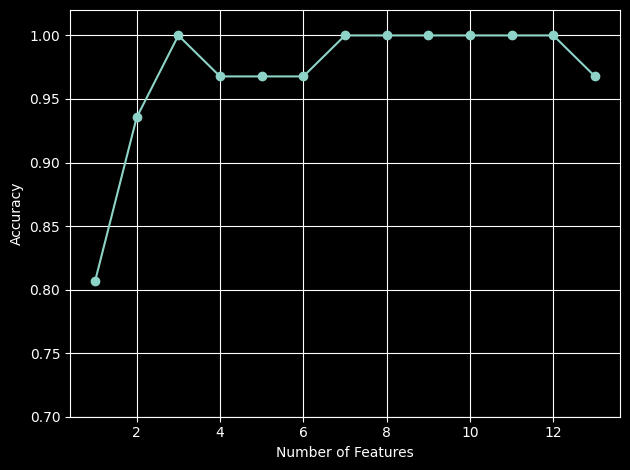

In [93]:
k_feat = [len(k) for k in sbs.subsets_]
plt.plot(k_feat, sbs.scores_, marker = 'o')
plt.ylim([0.7,1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of Features')
plt.grid()
plt.tight_layout()
plt.show()

### What are the 3 features in the features subset from the above graph?

In [94]:
k3 = list(sbs.subsets_[10])
print(df_wine.columns[1:][k3])

Index(['alcohol', 'malic acid', 'od280/od315 of diluted wines'], dtype='object')


### evaluating the KNN model on the full feature set from the wine data

In [95]:
knn.fit(x_train_std,y_train)
print('Training accuracy of the full features list:', knn.score(x_train_std,y_train))
print('Test dataset accuracy on the full feature set', knn.score(x_test_std,y_test))

Training accuracy of the full features list: 0.967741935483871
Test dataset accuracy on the full feature set 0.9814814814814815


### evaluating the KNN model on the subsetted dataset found from our SBS function

In [96]:
knn.fit(x_train_std.iloc[:,k3],y_train)
print('Training accuracy of the full features list:', knn.score(x_train_std.iloc[:,k3],y_train))
print('Test dataset accuracy on the full feature set', knn.score(x_test_std.iloc[:,k3],y_test))

Training accuracy of the full features list: 0.9516129032258065
Test dataset accuracy on the full feature set 0.9259259259259259


# Assessing Feature Importance using a random forest
#### Using a random forest, you could use a threshold of importance to downselect features based off importance. Notice that 3 of the top 5 features below are in the SBS method above...

In [97]:
from sklearn.ensemble import RandomForestClassifier

In [98]:
feat_labels = df_wine.columns[1:]
forest = RandomForestClassifier(n_estimators=500,
                                random_state=1)

forest.fit(x_train,y_train)

importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

 1) proline                        0.185453
 2) flavanoids                     0.174751
 3) color intensity                0.143920
 4) od280/od315 of diluted wines   0.136162
 5) alcohol                        0.118529
 6) hue                            0.058739
 7) total phenols                  0.050872
 8) magnesium                      0.031357
 9) malic acid                     0.025648
10) proanthocyanins                0.025570
11) alcalinity of ash              0.022366
12) nonflavanoid phenols           0.013354
13) ash                            0.013279


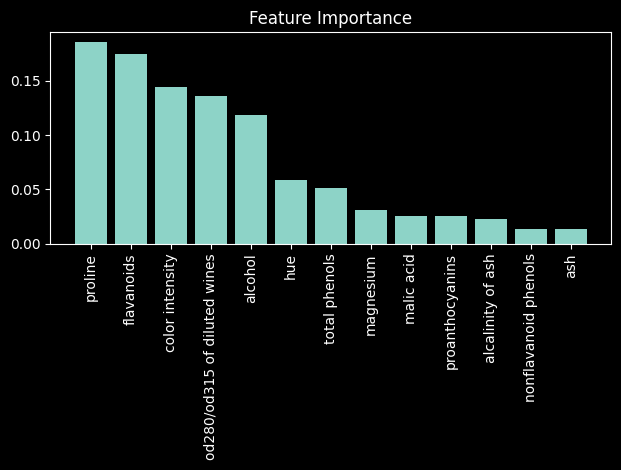

In [99]:
for f in range(x_train.shape[1]):
    print("%2d) %-*s %f" % (f+1,30,feat_labels[indices[f]], importances[indices[f]]))

plt.title('Feature Importance')
plt.bar(range(x_train.shape[1]),
        importances[indices],
        align='center')
plt.xticks(range(x_train.shape[1]),
           feat_labels[indices], rotation = 90)
plt.xlim(-1, x_train.shape[1])
plt.tight_layout()
plt.show()